# Machine Learning Demonstration

To run this notebook, you need to install python dependencies:

Install tensorflow:

With conda:

conda install -c conda-forge tensorflow

With pip:

pip install tensorflow==1.14.0

>If you have a GPU in your computer, you can install the gpu version to speed up some computations by following the instructions in this link: https://www.tensorflow.org/install/

Other dependencies:

With pip:

pip install numpy==1.17.2

pip install pandas==0.24.2

pip install matplotlib==2.2.2

pip install scipy==0.19.1

pip install xgboost==1.0.0

pip install gmaps==0.9.0

pip install geopandas==0.5.1


## Disaster Prevention (Floods)

Floods are the most destructive and dangerous natural disasters worldwide. All regions can be affected by flooding events and, with the increased variability in weather patterns due to global warming, this is likely to become even more prelevant [1]. The speed at which flooding events can occur, and difficulties in predicting their occurrance, create huge logistic problems for both governmental and non-governmental agencies. Over the past 10 years, floods have caused on average 95 deaths a year in the US alone, [2], making them the deadliest weather related phenomenon [3]. Worldwide, floods cost in excess of 40 Billion dollars per year [4], impacting property, agriculture and the health of individuals.

During the duration of the project, we collaborated with United States Geological Survey (USGS), a scientific agency within the US Department of the Interior. The objective of the organization is to study the landscape of the US and provide information about its natural resources and the natural hazards that affect them. Currently, hydrologists use physical models to help predict floods. These models require predictions to be carefully calibrated for each stream or watershed and careful consideration must be taken for dams, levees etc. Producing these models is extremely costly due to resource requirements. This limits the areas within the US that can avail of such systems to better prepare for flood events.


To predict the flood susceptibility of a stream area, the project was separated into two distinct problems.

Monthly Model

Predicting, per month, if a stream height will reach a flood threshold or not. These flood thresholds were set by the National Oceanic and Atmospheric Administration (NOAA) and were location specific. Knowing which areas are susceptible to flooding, allow locations to better prepare for a flood event.

Time to Peak Model

Predicting the time to peak of a flood event. When a major rain event occurs, knowing how long it will take for a river to reach its peak height is necessary in order to inform potentially affected individuals if and when they need to evacuate. This can help to reduce structural damage and loss of life during a disaster.



## The Data

This project focused on 6 states within the US, over a period of 10 years. Data was taken from ~800 gauge sites, between July 2009 and June 2019. Not all gauge sites had continuous historical data over the period, but all the available data for each site was used.

The six states were:

    -New Jersey
    -Nebraska
    -South Carolina
    -New York
    -South Dakota
    -Virginia
    
A primary reason for choosing these states, was that each exhibits similar climate and landscape. Focusing on similar geographies helped to ensure that the models produced were precise.

Other required datasets and providers:

**USGS**

This dataset was used to extract daily precipitation readings from the site locations for each day during the requested 10 year period.

**National Land Cover Database (NLCD)**

This provides information such as land-use classification (urban, agriculture, forest, etc.), how well the land allows water to pass through it (impervious surface information) and tree cover. This dataset has updated records every 5 years from 2006.

**National Hydrology Dataset Plus (NHDPlus)**

The features used from this dataset were the catchment and drainage area characteristics at the stream site locations. 

**Flooded Locations And Simulated Hydrographs Project (FLASH)**

The information used from this dataset was the time taken for a river to reach its peak height after a major rain event.

**NOAA**

This dataset provided flood level thresholds for locations across the US. These thresholds consisted of four warning stages and the river height for a given location that causes them to reach these levels. The four warning stages were

|Warning |Meaning                                                                                     |
|--------|-------                                                                                     |
|Action  |	Mitigation action needs to be taken in order to prepare for possible hydrological activity|
|Flood	 |The river height poses a threat to lives, property and businesses|
|Moderate| 	Some inundation of roads or buildings. A flood warning should be released|
|Major	 |Extensive inundation of roads and buildings. Considerable evacuations of areas may occur|

A more indepth discussion on these dataspurces can be found within the whitepaper section of code.kx

## Load Required Libraries

An implementation on how to download the stream heights from USGS over the 10 year period can be found in the stream.q file

In [1]:
// Load the machine learning toolkit
\l ml/ml.q 
.ml.loadfile`:init.q

// Load flood data and associated code
\l ../floods.q
.fld.loadfile`:init.q

### Cleaning up the Dataset 

As the datasets came from a variety of different sources, cleaning up the data to make them consistent was an important initial task before any feature engineering could be done.

The id number of each stream site consisted of over 8 digits. Any with less will be front loaded with 0's. 

Any nulls or infinity values from the dataset are also deleted

In [2]:
del:{![x;enlist (=;y;z);0b;`symbol$()]}
conv7_fn:{`$$[7=count x;"0",;]x}
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]
maxht :update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

Add in index column for the warnings table (will be used later for nearest neighbours)

In [3]:
warning:update nn:i from warnings

The PRISM dataset had an id limit of 12 digits, meaning that some of the site_no digits were excluded. To not lose datapoints when joining, the remaining digits were added back in

In [4]:
\t:1000 x:string exec distinct site_no from gauges
\t:1000 y:exec distinct string each site_no from gauges 
x~y

30


95


1b


In [5]:
rms  :asc ds where 12<count each ds:string exec distinct site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms

// What's so special about the 20'th x of the names table?
matchnames:0!select i by lat,long from precip where i in names[`x][20]


lst1:til[26]except 21 22
lst2:til[25]except 20

// i1 if ascending is exactly equivalent to `$asc rms[til 26] why is this ordering important
i1:`$rms[lst1],rms[21 22]
// i2 similar thing why was there a need to deal with the 20th x differently and add on?
i2:(names[`x]lst2),matchnames`x

precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Given the data available, it was possible to split the information into three datasets

1. Ungauged basin: Information available at sites that do not contain stream gauge or future forecasting information. Data was limited to land use, past rainfall and upstream information.

2. Gauged basin: All information contained within the ungauged basin dataset, as well as stream gauge information. This included previous river heights and lagged/aggregated flooding information.

3. Perfect Forecasts: All information contained within the gauged basin dataset, as well as precipitation information around the time of the event.

Seasonal Information plays an important role when predicting if an area will flood and how long it will take. The sin and cos of each month of the year was calculated

In [6]:
pi:acos -1
// why is this naming convention used?
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip
precip:`date xasc update month:`mm$date from precip
// why are sine and cosine months important? any reason for the 1->0 ... 12->11 vs. using 1->12 as months?
precip:update cos_t:cos 2*pi*(month-1)%11,sin_t:sin 2*pi*(month-1)%11 from precip
// what is the reason for this standarization decision?
stryear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:stryear from precip

To obtain these features, the feat function was used to extract previous information along with windowed features. This function takes the following parameters as input:


feat:

`x`    table that's being updated

`y`    how many values to calculate (integer list)

`z`    column to apply the function to (symbol)
        
`col`  new column name (symbol)
        
`d`    dictionary of where, groupby and what type of functional statement is used
        
`fnc`  function that is applied to the grouped columns


In [7]:
colname:{enlist`$string[y],"_",string[x],"_",string[z]}
// rename to max_mavg? more implicit defn
m_avg:{(max;(mavg;y;x))}
prv:{(xprev;y;x)}

// concerned that these functions do too much
func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}
feat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]func[y;col;;fnc]each z]}

To obtain the upstream values the feat function was used. The id number of each stream site consisted of over 8 digits. The first two digits were the grouping number of the river basin catchment. While the remaining digits were in ascending order based on the location of the gauge along the stream.

In [8]:
catch_site:((';#);2;($:;`site_no))
site_date:`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)
upstr_ppt:feat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:feat[maxht;1;`height;`upstr;dict;prv]

The feat function was also used to obtain previous values of both rainfall and stream gauge height readings before each date, for both the current location and sites upstream.

In [9]:
dict[`gr]:site:(enlist `site_no)!enlist `site_no
prev_rain:feat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:feat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

The above features were applicable to both aspects of this project. However, additional features that were problem specific were also added.

### Monthly Models

When forecasts are provided for each model, knowing how the average rainfall will change over differnet window sizes for each month is a feature that can be added to the dataset.

In [10]:
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)
all_rain:feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;m_avg]

By taking the first day of each month at a site, it was possible to obtain the maximum moving averages of precipitation for different window sizes for a given month, along with the precipitation and height values for the last few days of the month prior.

In [11]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data:update date:"m"$date from select from all_rain where 1=`dd$date

Join the stream height and rain data based on site number and month

In [12]:
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

For the time to peak dataset the daily rain and height data is joined to the FLASH dataset based on the site number and date along with the stream_char dataset.

In [13]:
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

#### prev window

The hours before a flood event can provide important information on how quickly the stream gauge height is moving. This is incredibly useful to a model predicting how long it will take for the stream to reach its peak height. The information extracted at a given stream location, comprised of the maximum moving averages over different bucket sizes for the two days before the event. This was found using stream height data from USGS, which was updated at 15 minute intervals.

To make the times from the stream height dataset consistent with the FLASH dataset, the times were converted to be time zone agnostic.

These zones consist of 

    -EDT: Eastern Daylight Time
    -CDT: Central Daylight Time
    -EST: Eastern Standard Time

In [14]:
time_zone:raze{dd:x[1];si:x[0];
          select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
          value each 0!select date by distinct site_no from peak_data;
peak_data:peak_data ij`site_no xkey time_zone
change_zone:{$[y=`EDT;x-04:00;y=`CDT;x-05:00;x-06:00]}

The start-time, end-time and peak-time during the event were affected by this. The date also needed to be updated in some cases to coincide with the time change.

In [15]:
peak_data[`start_time`end_time`peak_time]:change_zone''[;peak_data`unk]each peak_data`start_time`end_time`peak_time
peak_data[`date]:`date$peak_data`start_time

The previous hours before the flood event occurs can show information on how quickly the stream gauge height is moving which can be useful to the model in predicting how long it will take to peak. To do this the 2 days before the event are extracted, and moving averages of different sizes are applied to the stream height dataset

In [16]:
range:{(within;x;(,;(+;(-:;2);y);y))}
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;x[0];($;enlist`;`site_no)))}
dict:{`w`wh`gr!(?;wh x;0b)}
wind_ht_prev:{feat[str;enlist 2 4 12 48;`height;`wind_prev;dict x;m_avg]}each 
             flip peak_data[`site_no`date`start_time]

This was joined back to the dataset with any nulls or infinity values excluded

In [17]:
peak_data:peak_data,'raze wind_ht_prev
peak_data:del[peak_data;`wind_prev_height_2;neg[0w]]

For models that use rain forecasts, knowing what the coming days rainfall would be after the event in question was also added to the model

In [18]:
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;y[0];`site_no))}
dict:{`w`wh`gr!(?;wh[x;y];0b)}
rain_pred:{feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];m_avg]}[3]
          each flip peak_data[`site_no`date]
peak_data:peak_data,'raze rain_pred

## Target Data

### Monthly Models

The target data used in this case was the Flood level warning, extracted from the NOAA dataset.

The latitude and longitude of these provided thresholds did not exactly match the stream gauge locations. As such, the latitudes and longitudes of both the stream locations and NOAA threshold readings were joined using a k-dimensional tree (kd-tree) nearest neighbours algorithm. 

In [19]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

The index of the nearest neighbour was added as a column so that the warning level dataset could be joined with the max stream height table.

In [20]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

In [21]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

For the sake of this project, we only want to predict if the "Flood" level was reached or not for a site during a given month. Our target data is a binary label of whether this was reached or not.

Any site that floods more than 28 days per month is omitted from the dataset

In [22]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

After a major rain event, it is important to know how long to will take for the stream to reach peak height.

The FLASH dataset will be used as ground thruth, which highlights how long it will take to reach this peak height, only dates and site numbers used in the rain and height will be extracted.

In [23]:
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

To predict how long it will take to flood, we have classified this problem as a binary class of whether or not it will take longer than 3 hours. This is important to know how long people have to evacuate from the area when a Flood warning is given.

In [24]:
peak_data[`target]:peak_data[`delta_peak]<3.5

## Joining the characteristics tables 

Join the basin characteristics to the NLCD landcover dataset based on site_no.

In [25]:
stream_char:nlcd ij`site_no xkey basin
all_peak_data:peak_data ij`site_no`year xkey stream_char
all_monthly_data:(monthly_data ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

#### Lagged features

For gauged basins, having knowledge of if an area has flooded in the past or not is also an important feature to extract

In [26]:
all_monthly_data:feat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]
tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[tgts;();();`no_Flood]

## Train Test Split

Delete any rows from the dataset that contains a null

In [27]:
del_null:{where not any each null x}
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

In [28]:
fnd_col:{x where x in y}
ungauged_noforecast_basinM:fnd_col[ungauged_noforecast_basin;cols cleaned_monthly]
gauged_basinM:             fnd_col[gauged_basin;cols cleaned_monthly]
perfect_forecastM:         fnd_col[perfect_forecast;cols cleaned_monthly]
ungauged_noforecast_basinP:fnd_col[ungauged_noforecast_basin;cols cleaned_peak]
gauged_basinP:             fnd_col[gauged_basin;cols cleaned_peak]
perfect_forecastP:         fnd_col[perfect_forecast;cols cleaned_peak]

In [29]:
ungauge: `M`P!(ungauged_noforecast_basinM;ungauged_noforecast_basinP)
gauge:   `M`P!(ungauge[`M],gauged_basinM;ungauge[`P],gauged_basinP)
forecast:`M`P!(gauge[`M],perfect_forecastM;gauge[`P],perfect_forecastP)

In [30]:
split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

### Monthly Models

Split the train and test up by date, so that only past data is contained in the training set. A date was chosen so that 20 percent of the dataset is in the testing set

In [31]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainMi:select from cutoff where date<cutoff
ytrainM:exec target from cutoff where date<cutoff
XtestMi:select from cutoff where date>=cutoff
ytestM:exec target from cutoff where date>=cutoff

XtrainM:split_dict[XtrainMi;`M]
XtestM:split_dict[XtestMi;`M]

### Time to Peak Model

The time to peak data is separated so that sites do not appear in both the train and test dataset. To distribution the sum of the target per site is shown below. This dataset is separated into equally distributed bins and the train and test split is stratified by this split

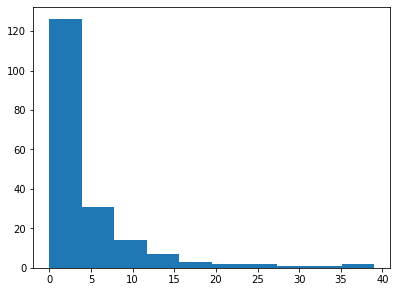

In [32]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

In [33]:
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

In [34]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

In [35]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
XtestP:split_dict[XtestPi;`P]

## Run Models

Gradient Boosts and Random forests were applied to the train and test datasets and the results were printed as a precision/recall curve. This metric was chosen as getting a balance between precision and recall when predicting floods is pivitol to ensure that all floods are given warnings but also not too many false warnings are given. The inputs to the pr_curve are

    -Xtest
    -ytest
    -dictionary of models that are being used


In [36]:
build_model:{[Xtrain;ytrain;dict]
 rf_clf:      RandomForestClassifier[`n_estimators pykw dict`rf_n;`random_state pykw 0;
            `class_weight pykw(0 1)!(1;dict`rf_wgt)][`:fit][Xtrain; ytrain];
 xgboost_clf: xgboost_clf: XGBClassifier[`n_estimators pykw dict`xgb_n;`learning_rate pykw 
              dict`xgb_lr;`random_state pykw 0;`scale_pos_weight pykw dict`xgb_wgt;
              `max_depth pykw dict`xgb_maxd][`:fit][np[`:array]Xtrain; ytrain];
 `random_forest`XGB!(rf_clf;xgboost_clf)}

## Ungauged Prediction 

### Monthly Models

In [42]:
\l ../../code/models.q


Accuracy for random_forest: 0.9392063


Meanclass accuracy for random_forest: 0.8513272


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9427977 0.9949254 0.9681604 13203  
1        | 0.7598566 0.210109  0.3291925 1009   
avg/total| 0.8513272 0.6025172 0.6486765 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9207008


Meanclass accuracy for XGB: 0.6914636


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9520138 0.9631902 0.9575694 13203  
1        | 0.4309133 0.3647175 0.3950617 1009   
avg/total| 0.6914636 0.6639539 0.6763155 14212  


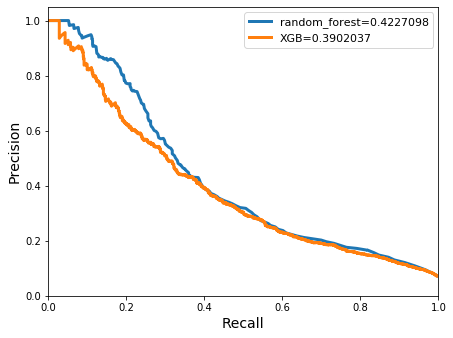

In [43]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)
pltU1:pr_curve[XtestM`ungauged;ytestM;build_model[XtrainM`ungauged;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7416974


Meanclass accuracy for random_forest: 0.7308405


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7452632 0.9490617 0.8349057 373    
1        | 0.7164179 0.2840237 0.4067797 169    
avg/total| 0.7308405 0.6165427 0.6208427 542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7730627


Meanclass accuracy for XGB: 0.7376155


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8109453 0.8739946 0.8412903 373    
1        | 0.6642857 0.5502959 0.6019417 169    
avg/total| 0.7376155 0.7121452 0.721616  542    


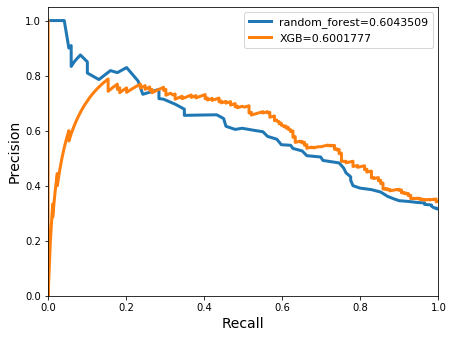

In [44]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;.01;1.5;3)
pltU2:pr_curve[XtestP`ungauged;ytestP;build_model[XtrainP`ungauged;ytrainP;dict]]

## Gauged Prediction

### Monthly Models


Accuracy for random_forest: 0.9435688


Meanclass accuracy for random_forest: 0.9067069


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9450865 0.9971976 0.970443  13203  
1        | 0.8683274 0.2418236 0.3782946 1009   
avg/total| 0.9067069 0.6195106 0.6743688 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9332254


Meanclass accuracy for XGB: 0.7474907


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9554036 0.9735666 0.9643996 13203  
1        | 0.5395778 0.4053518 0.4629315 1009   
avg/total| 0.7474907 0.6894592 0.7136656 14212  


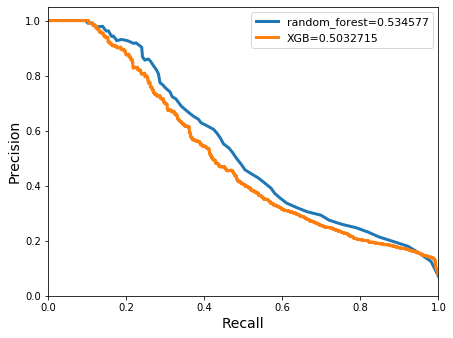

In [45]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)
pltG1:pr_curve[XtestM`gauged;ytestM;build_model[XtrainM`gauged;ytrainM;dict]]

### Time to Peak Model


Accuracy for random_forest: 0.7205882
Meanclass accuracy for random_forest: 0.6982818


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7298969 0.9490617 0.8251748 373    
1        | 0.6666667 0.2248521 0.3362832 169    
avg/total| 0.6982818 0.5869569 0.580729  542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7610294
Meanclass accuracy for XGB: 0.7325731


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7868852 0.9008043 0.84      373    
1        | 0.6782609 0.4615385 0.5492958 169    
avg/total| 0.7325731 0.6811714 0.6946479 542    


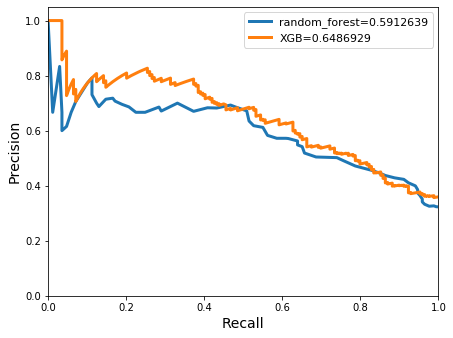

In [40]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;360;0.01;1.5;3)
pltG2:pr_curve[XtestP`gauged;ytestP;build_model[XtrainP`gauged;ytrainP;dict]]

## Perfect Forecast

### Monthly Models


Accuracy for random_forest: 0.9438503


Meanclass accuracy for random_forest: 0.9116512


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9451662 0.9974248 0.9705926 13203  
1        | 0.8781362 0.2428147 0.3804348 1009   
avg/total| 0.9116512 0.6201197 0.6755137 14212  


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.9475091


Meanclass accuracy for XGB: 0.8037618


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9698273 0.9737938 0.9718065 13203  
1        | 0.6376963 0.6035679 0.6201629 1009   
avg/total| 0.8037618 0.7886809 0.7959847 14212  


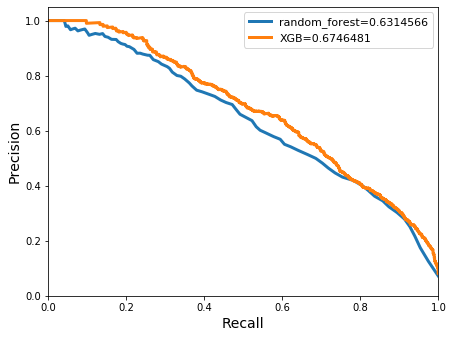

In [46]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)
pltP1:pr_curve[XtestM`forecast;ytestM;build_model[XtrainM`forecast;ytrainM;dict]]

### Time to Peak Model

In [42]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)
pltP2:pr_curve[XtestP`forecast;ytestP;build_model[XtrainP`forecast;ytrainP;dict]]


Accuracy for random_forest: 0.7536765
Meanclass accuracy for random_forest: 0.7768992


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7505198 0.9678284 0.8454333 373    
1        | 0.8032787 0.2899408 0.426087  169    
avg/total| 0.7768992 0.6288846 0.6357601 542    


/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Accuracy for XGB: 0.7628676
Meanclass accuracy for XGB: 0.7266119


class    | precision recall   f1_score  support
---------| ------------------------------------
0        | 0.8203125 0.844504 0.8322325 373    
1        | 0.6329114 0.591716 0.6116208 169    
avg/total| 0.7266119 0.71811  0.7219266 542    


### Feature Significance

In [43]:
title:{"The top 15 significant features for the ",x," predicts are:"}

In [44]:
title["monthly"]
string .ml.fresh.significantfeatures[flip forecast[`M]!cleaned_monthly[forecast[`M]];
 cleaned_monthly`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the monthly predicts are:"


"lagged_target_all"
"window_ppt_1"
"window_ppt_2"
"window_ppt_3"
"window_ppt_4"
"window_ppt_5"
"window_ppt_6"
"window_upstr_ppt_1_1"
"window_upstr_ppt_1_2"
"window_upstr_ppt_1_3"
"window_upstr_ppt_1_4"
"window_upstr_ppt_1_5"
"window_ppt_7"
"window_ppt_9"
"window_upstr_ppt_1_6"


In [45]:
title["time-peak"]
string .ml.fresh.significantfeatures[flip forecast[`P]!cleaned_peak[forecast[`P]];
 cleaned_peak`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features for the time-peak predicts are:"


"WsAreaSqKmRp100"
"WsAreaSqKm"
"wind_prev_height_48"
"prev_upstr_height_1_1"
"wind_prev_height_12"
"prev_height_1"
"prev_height_5"
"WetIndexCat"
"prev_height_4"
"prev_height_6"
"prev_height_7"
"prev_height_2"
"prev_height_8"
"wind_prev_height_4"
"prev_height_3"


## Graphics 

In [46]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt

In [47]:
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

In [48]:
pred:last pltU2`model
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2


rainfall:`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound:`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(value pg`site_no)=`$site_no

plt[`:plot][graph`datetime;graph`height;`label pykw `height;`linewidth pykw 3];
pltline:{plt[`:axvline][x`x_val;`color pykw x`col;`label pykw x`title;`linewidth pykw 3];}
pltline each (rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we can predict with high accuracy whether an area will flood or not using particular models and input data

For the monthly models, the future weather predictions play an important role in predicting whether an area will flood or not, with the accuracy and other metrics such as recall and precision decreasing as the weather predictions and gauged information columns are excluded from the dataset. This corresponds with the results from the significant feature tests, with lagged_target_information and also the windowed rain values of the current month.

The opposite was true for the time-peak values, as previous rain and stream gauge information along with the basin characteristics were seen to be the most significant features when predicting these values. Including additional information about the future predicted rainfall decreased the accuracy of the results, with the best results being obtained from the model with only past rainfall and and basin and soil characteristics being fed into the model.

The best results from the models above were obtained by continuously adjusting the parameters of the model. The unbalanced target data in the monthly model meant that weighting the classes was an important feature to experiment with, in particular concerning trying to obtain high precision and recall results. In both models, the results between the recall and precision metrics were most balanced using xgboost.

Xgboost and Random Forests were favoured over neural net models as overfitting to the training set was a common feature with very low recall and precision results obtained. This was also seen in the raster results, where the models performed marginally better in the training set, but failed to pick up any meaningful results in the validation or testing set.


